In [1]:
%pip install ultralytics 
%pip install scikit-learn
import cv2 as cv
import numpy as np
import os
from matplotlib import pyplot as plt
from ultralytics import YOLO
from IPython.display import display, Image
from IPython import display
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from PIL import Image
from torch.utils.data import random_split
from sklearn.metrics import accuracy_score


display.clear_output()

In [4]:
#uncomment to download the dataset

# %pip install roboflow
# from roboflow import Roboflow
# rf = Roboflow(api_key="_")#must write your own key
# project = rf.workspace("connectfour").project("connect4-bmekp")
# version = project.version(3)
# dataset = version.download("yolov8")
# display.clear_output()
#might need to modify paths in data.yaml

In [ ]:
#uncomment to train the yolov8 model

# !yolo task=segment mode=train model=yolov8n-seg.pt data={dataset.location}/data.yaml epochs=20 imgsz=640 #train
# !yolo task=segment mode=val model=/content/runs/segment/train2/weights/best.pt data={dataset.location}/data.yaml #validation
# !yolo task=segment mode=predict model=runs/segment/train2/weights/best.pt conf=0.7 source="Connect4-3/test/images" save = False

#another way of writing testing, to save the results

# model = YOLO('runs/segment/train2/weights/best.pt')  
# results = model("Connect4-3/test/images")

In [14]:
#to split the image into 42 pieces

def make_squares(img):

    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    img = Image.fromarray(img)
    # Create a directory to save the smaller images
    output_dir = "pieces/test"
    os.makedirs(output_dir, exist_ok=True)

    # Define the size of each square image
    tile_width = 100
    tile_height = 100

    # Calculate the number of rows and columns
    rows = 6
    cols = 7

    # Loop through the image and save each 100x100 px square
    for row in range(rows):
        for col in range(cols):
            left = col * tile_width
            upper = row * tile_height
            right = left + tile_width
            lower = upper + tile_height
            
            # Crop the image
            cropped_img = img.crop((left, upper, right, lower))
            
            # Save the cropped image
            cropped_img.save(os.path.join(output_dir, f"tile_{row}_{col}.jpg"))

    print(f"All tiles have been saved in the '{output_dir}' directory.")


In [15]:
#ml model to predict pieces (mobileNet)

def train_model(model, train_loader, criterion, optimizer,num_epochs,device):

    model.train()  # Set model to training mode

    for epoch in range(num_epochs):
        running_loss = 0.0

        for inputs, labels in train_loader:
            # Move data to the GPU
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

    print("Training complete")

def validate_model(model, val_loader, criterion,device):

    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move data to the GPU
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Validation Loss: {running_loss/len(val_loader)}, Accuracy: {accuracy}%')

def train_and_validate():

    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize images to 224x224 as required by MobileNet
        transforms.ToTensor(),          # Convert images to PyTorch tensors
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet means and stds
    ])

    # Set the device to GPU 
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load data using ImageFolder
    dataset = datasets.ImageFolder(root='pieces/organized', transform=transform)

    # Define the proportion of validation data
    val_split = 0.2  # 20% of the data for validation

    # Split dataset
    train_size = int(0.8 * len(dataset))  # 80% for training
    val_size = len(dataset) - train_size   # Remaining for validation
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create DataLoader for validation and train set
    val_loader = DataLoader(val_dataset, batch_size=10, shuffle=True)

    train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

    # Load a pre-trained MobileNet model
    model = models.mobilenet_v2(weights=True)

    # Modify the classifier
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(model.classifier[1].in_features, 1280),  # Increase dimensionality to match the Conv2d input
        nn.ReLU(),
        nn.Unflatten(1, (40, 32, 1)),  # Reshape to match Conv2d input
        nn.Conv2d(in_channels=40, out_channels=128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d((1, 1)),  # Pooling to reduce dimensionality
        nn.Flatten(),
        nn.Linear(128, 3)  # Final classification layer
    )

    # Move the model to the device
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer=optim.Adam(model.parameters(), lr=0.00005)

    train_model(model, train_loader, criterion, optimizer, 50, device)

    validate_model(model, val_loader, criterion, device)

    # uncomment to save the model's state dictionary
    # torch.save(model.state_dict(), 'my_model.pth')

In [17]:
#evaluate the model on an image

def predict_image(image_path, model, device,transform):
    #Predict the class of a single image using the trained model.
    image = Image.open(image_path)
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    image = image.to(device)    # Move the image to GPU if available
    
    with torch.no_grad():  # No need to compute gradients
        outputs = model(image)  # Perform inference
        _, predicted = torch.max(outputs, 1)  # Get the predicted class index
    
    return predicted.item()  # Return the predicted class index

def predict_folder(folder_path, model, device, transform):
    #predict the class for each image in a folder.

    # List and sort files in the directory
    filenames = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    sorted_filenames = sorted(filenames)
    
    for filename in sorted_filenames:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)
            predicted_class = predict_image(image_path, model, device, transform)
            print(f'Image: {filename}, Predicted Class: {predicted_class}')


def test_model():

    # Define transforms
    transform = transforms.Compose([
            transforms.Resize((224, 224)),  # Resize images to 224x224 as required by MobileNet
            transforms.ToTensor(),          # Convert images to PyTorch tensors
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet means and stds
        ])

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Define the model architecture
    model = models.mobilenet_v2(pretrained=False)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(model.classifier[1].in_features, 1280),  # Increase dimensionality to match the Conv2d input
        nn.ReLU(),
        nn.Unflatten(1, (40, 32, 1)),  # Reshape to match Conv2d input
        nn.Conv2d(in_channels=40, out_channels=128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d((1, 1)),  # Pooling to reduce dimensionality
        nn.Flatten(),
        nn.Linear(128, 3)  # Final classification layer
    )

    model.load_state_dict(torch.load('dropout_ReLU.pth'))
    model.to(device)  # Move the model to the GPU if available
    model.eval()      # Set the model to evaluation mode


    # Define the path to the folder containing images
    folder_path = 'pieces/test'

    # Predict the classes for all images in the folder
    predict_folder(folder_path, model, device, transform)

In [18]:
def Connect4BFS(matrix, start): #bfs to find closest edge of the border from the start point

    (x, y)= start
    if matrix[x][y] > 0:
        return [y, x]

    qe = [(x, y)]
    visited = set()
    visited.add((x, y))

    height = 640
    length = 640

    dx=[1, 0, -1, 0]
    dy=[0, 1, 0, -1]

    while qe:
        x, y = qe.pop(0)

        # Explore the neighboring nodes
        for k in range(4):
            nx = x+dx[k]
            ny = y+dy[k]
            if 0 <= nx < length and 0 <= ny < height:
                if (nx, ny) not in visited:
                    visited.add((nx, ny))
                    qe.append((nx, ny))
                if matrix[nx][ny] ==1:
                    return [ny, nx]                
                  
def Connect4GetBoard(image,matrix): #stretch image so that the border of the playable board fits in a 700x600 rectangle

    ul= Connect4BFS(matrix, (0,0)) #left up
    ur= Connect4BFS(matrix, (0,639)) #right up
    dr= Connect4BFS(matrix, (639,639)) #right down
    dl= Connect4BFS(matrix, (639,0)) #left down 

    image = cv.imread(image)
    result = image.copy()

    margin = 4
    ul[0] -= margin
    ul[1] -= margin
    ur[0] += margin
    ur[1] -= margin
    dr[0] += margin
    dr[1] += margin
    dl[0] -= margin
    dl[1] += margin

    # cv.circle(result, ul, 10, (255,0,0))
    # cv.circle(result, ur, 10, (255,0,0))
    # cv.circle(result, dr, 10, (255,0,0))
    # cv.circle(result, dl, 10, (255,0,0))
    
    src = np.array([ul, ur, dr, dl], dtype="float32")
    dst = np.array([[0, 0], [0, 700], [600, 700],[600, 0] ], dtype="float32")
    m = cv.getPerspectiveTransform(src, dst)
    result = cv.warpPerspective(image, m, (600, 700))
    result = cv.rotate(result, cv.ROTATE_90_CLOCKWISE)
    result = cv.flip(result, 1)

    return result

def Connect4MakeGrid(mask): #makes a matrix (640x640) of points with mask contour
  
  mask = mask.xy[0]
  
  grid = np.zeros((640,640))
  for pair in mask:
    grid [int(pair[1])] [int(pair[0])] = 1

  # plt.imshow(grid)
  return grid

def DetectPiece(region):

     # Convert region to HSV for better color segmentation
    hsv = cv.cvtColor(region, cv.COLOR_BGR2HSV)
    
    # Define color ranges for red and yellow
    red_lower1 = np.array([0, 120, 70])
    red_upper1 = np.array([10, 255, 255])
    red_lower2 = np.array([170, 120, 70])
    red_upper2 = np.array([180, 255, 255])
    
    yellow_lower = np.array([20, 100, 100])
    yellow_upper = np.array([30, 255, 255])
    
    # Create masks for red and yellow
    mask_red1 = cv.inRange(hsv, red_lower1, red_upper1)
    mask_red2 = cv.inRange(hsv, red_lower2, red_upper2)
    mask_red = cv.bitwise_or(mask_red1, mask_red2)
    mask_yellow = cv.inRange(hsv, yellow_lower, yellow_upper)
    
    # Check for the presence of each color in the region
    red_presence = np.sum(mask_red > 0)
    yellow_presence = np.sum(mask_yellow > 0)
    
    # Determine if a piece is present and its color
    if red_presence > yellow_presence and red_presence > 1200:  # threshold for minimum presence
        return 1 #red
    elif yellow_presence > red_presence and yellow_presence > 1000:
        return 2 #yellow
    else:
        return 0 #empty
    
def get_state_with_Ml(board,model,transform,device):

    game = np.zeros((6, 7)).astype(int)
    # we have a 700x600 image that we want to split into 100x100 squares, which we will then 
    # run some computer vision techniques to figure out the piece present
    for row in range (6):
        for col in range(7):
            region = board[row*100:(row+1)*100, col*100:(col+1)*100]
            
            # Convert the region to a PIL image and apply transformations
            region_pil = Image.fromarray(cv.cvtColor(region, cv.COLOR_BGR2RGB))
            region_tensor = transform(region_pil).unsqueeze(0)  # Add batch dimension
            region_tensor = region_tensor.to(device)  # Move to GPU if available
            
            # Perform inference
            with torch.no_grad():
                outputs = model(region_tensor)
                _, predicted = torch.max(outputs, 1)  # Get the predicted class index
            
            game[row][col] = predicted.item()  # Store the prediction in the game board matrix

    for line in game:
        print(*line)
    
    state = cv.cvtColor(board, cv.COLOR_BGR2RGB)
    plt.imshow(state)
    plt.show()

    return game

def GetState(board):

    game = np.zeros((6, 7)).astype(int)
    # we have a 700x600 image that we want to split into 100x100 squares, which we will then 
    # run some computer vision techniques to figure out the piece present
    for row in range (6):
        for col in range(7):
            region = board[row*100:(row+1)*100, col*100:(col+1)*100]
            game[row][col] = DetectPiece(region)
    print("the detected board")
    for line in game:
        print(*line)
    
    state = cv.cvtColor(board, cv.COLOR_BGR2RGB)
    plt.imshow(state)


    return game

def Connect4Run(image):
  
  yolo_model = YOLO(model="best.pt") #load trained model, must change path
  # results = model('/content/Connect4-3/test/images') #test model and save results
  result = yolo_model(source=image,  save=False)
  if result[0].masks is None:
      print("No masks detected")
      return
  # Get masks from the results from the segmentation model
  mask = result[0].masks
  grid = Connect4MakeGrid(mask)
  board = Connect4GetBoard(image,grid)

  # Set the device to GPU 
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  model = models.mobilenet_v2(weights=False)
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(model.classifier[1].in_features, 1280),  # Increase dimensionality to match the Conv2d input
    nn.ReLU(),
    nn.Unflatten(1, (40, 32, 1)),  # Reshape to match Conv2d input
    nn.Conv2d(in_channels=40, out_channels=128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)),  # Pooling to reduce dimensionality
    nn.Flatten(),
    nn.Linear(128, 3)  # Final classification layer
  )

  model.load_state_dict(torch.load('dropout_ReLU.pth'))
  model.to(device)  # Move the model to the GPU if available
  model.eval()      # Set the model to evaluation mode
  

# uncomment to save images of the pieces of the board 
#   make_squares(board)

# uncomment for old piece detection, with hsv masks
# game = GetState(board)

        # Define transforms
  transform = transforms.Compose([
      transforms.Resize((224, 224)),  # Resize images to 224x224 as required by MobileNet
      transforms.ToTensor(),          # Convert images to PyTorch tensors
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet means and stds
    ])
  
  game = get_state_with_Ml(board, model,transform,device)


image 1/1 /home/julie/Github/ConnectFour/backend/Connect4-3/train/images/30_webp.rf.396adc095856b0c50ee503ef4e4d058a.jpg: 640x640 1 board, 68.9ms
Speed: 3.4ms preprocess, 68.9ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)
0 0 0 0 0 0 0
0 0 0 0 0 0 0
0 0 0 0 2 0 0
0 0 1 0 2 2 1
2 2 1 2 2 1 1
1 2 2 1 1 2 1


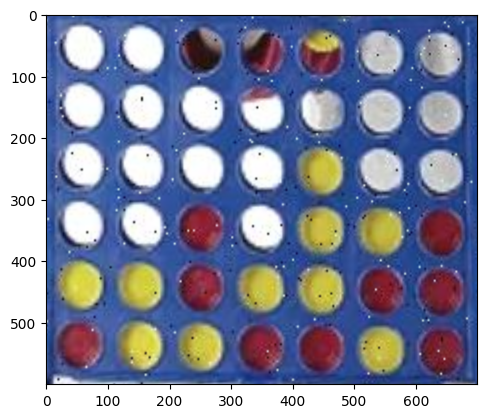

In [13]:
# path = "Connect4-3/valid/images/20240325_134951_jpg.rf.9f3f54fa68f52a825839fcc366fac18e.jpg"
path = "Connect4-3/train/images/30_webp.rf.396adc095856b0c50ee503ef4e4d058a.jpg"
Connect4Run(path)